In [19]:
# Import modules
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Categorical, Real, Int


In [20]:
# Load and prepare data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["target"])

In [21]:
# Split data (70% train, 10% val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)  

In [22]:
# Defining Model
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [23]:
# Manual Training 
def manual_train(batch_size, lr, epochs):
    model = IrisNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Convert data to tensors
    X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.long)
    
    # Store training history
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            outputs = model(X_tensor[i:i+batch_size])
            loss = criterion(outputs, y_tensor[i:i+batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history['train_loss'].append(epoch_loss/len(X_train))
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, torch.tensor(y_val.values.flatten(), dtype=torch.long))
            history['val_loss'].append(val_loss.item())
    
    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
        test_preds = torch.argmax(test_outputs, 1).numpy()
        
    return {
        'metrics': (accuracy_score(y_test, test_preds),
                   f1_score(y_test, test_preds, average='weighted')),
        'history': history,
        'model': model,
        'preds': test_preds
    }


In [24]:
# Run manual search
manual_results = []
configs = [(bs, lr, ep) for bs in [2,4] for lr in [1e-3,1e-5] for ep in [1,3,5]]

for bs, lr, ep in configs:
    result = manual_train(bs, lr, ep)
    manual_results.append({
        'batch_size': bs,
        'lr': lr,
        'epochs': ep,
        'accuracy': result['metrics'][0],
        'f1': result['metrics'][1],
        'history': result['history'],
        'model': result['model'],
        'preds': result['preds']
    })

# Create comparison dataframe
manual_df = pd.DataFrame(manual_results)

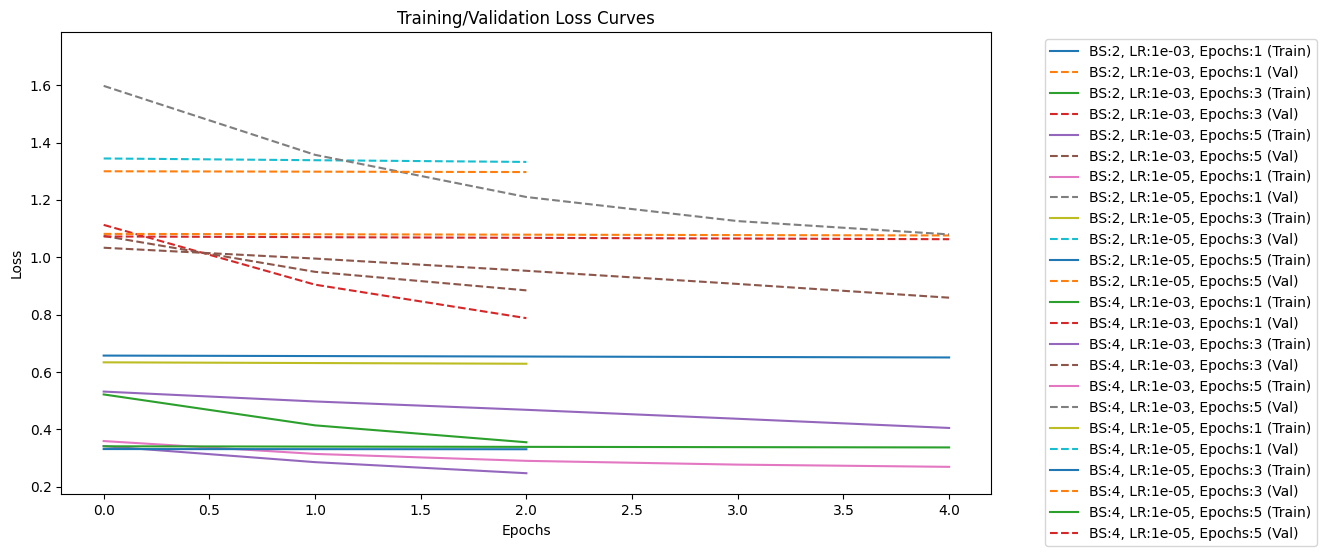

In [25]:
# Plot loss curves
plt.figure(figsize=(12,6))
for res in manual_results:
    label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"
    plt.plot(res['history']['train_loss'], label=label+' (Train)')
    plt.plot(res['history']['val_loss'], '--', label=label+' (Val)')
plt.title("Training/Validation Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

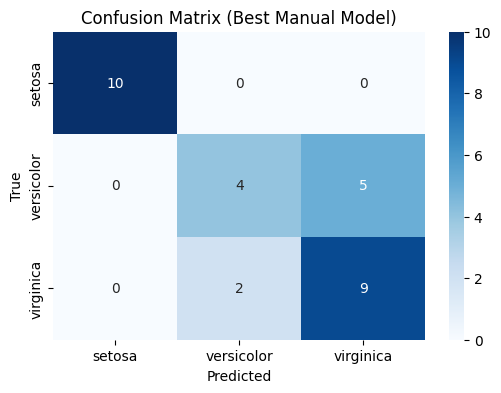

In [26]:
# Plot confusion matrix for best model
best_model = manual_df.loc[manual_df['f1'].idxmax()]
cm = confusion_matrix(y_test, best_model['preds'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=data.target_names,
           yticklabels=data.target_names)
plt.title("Confusion Matrix (Best Manual Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [27]:
# Show sample predictions
sample_idx = np.random.choice(len(X_test), 5, replace=False)
print("\nSample Predictions:")
for idx in sample_idx:
    features = X_test.iloc[idx].values
    true = data.target_names[y_test.iloc[idx].values[0]]
    pred = data.target_names[best_model['preds'][idx]]
    print(f"Features: {features} | Predicted: {pred:8} | True: {true}")


Sample Predictions:
Features: [6.1 3.  4.9 1.8] | Predicted: virginica | True: virginica
Features: [6.4 2.8 5.6 2.1] | Predicted: virginica | True: virginica
Features: [4.8 3.  1.4 0.3] | Predicted: setosa   | True: setosa
Features: [5.8 2.7 3.9 1.2] | Predicted: versicolor | True: versicolor
Features: [6.5 3.2 5.1 2. ] | Predicted: virginica | True: virginica


In [28]:
# Autogluon Search
def run_autogluon_search(method):
    try:
        hyperparams = {
            'NN_TORCH': {
                'num_epochs': Int(1,5),
                'learning_rate': Real(1e-5,1e-3),
                'batch_size': Categorical(2,4)
            }
        }
        
        path = f"{method}_model"
        if os.path.exists(path):
            shutil.rmtree(path)
            
        predictor = TabularPredictor(
            label="target",
            path=path,
            eval_metric='f1_weighted'
        ).fit(
            train_data=pd.concat([X_train, y_train], axis=1),
            tuning_data=pd.concat([X_val, y_val], axis=1),
            hyperparameters=hyperparams,
            hyperparameter_tune_kwargs={
                'num_trials': 5,
                'searcher': method,
                'scheduler': 'local'
            },
            time_limit=300
        )
        
        test_pred = predictor.predict(pd.concat([X_test, y_test], axis=1))
        return {
            'accuracy': accuracy_score(y_test, test_pred),
            'f1': f1_score(y_test, test_pred, average='weighted')
        }
    except Exception as e:
        print(f"{method} search failed: {str(e)}")
        return {'accuracy':0, 'f1':0}


In [29]:
# Random Search
random_result = run_autogluon_search('random')

Fitted model: NeuralNetTorch\59099_00000 ...
	0.7916	 = Validation score   (f1_weighted)
	4.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\59099_00001 ...
	0.8705	 = Validation score   (f1_weighted)
	5.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\59099_00002 ...
	1.0	 = Validation score   (f1_weighted)
	6.25s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\59099_00003 ...
	0.6579	 = Validation score   (f1_weighted)
	6.13s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\59099_00004 ...
	0.8705	 = Validation score   (f1_weighted)
	5.28s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.96s of the 285.94s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\59099_00002': 1.0}
	1.0	 = Validation score   (f1_weighted)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon trai

In [30]:
# Bayesian Optimization
bayes_result = run_autogluon_search('bayes')

Fitted model: NeuralNetTorch\e34ae1ab ...
	0.7916	 = Validation score   (f1_weighted)
	3.65s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\e9f3c678 ...
	1.0	 = Validation score   (f1_weighted)
	3.64s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\86ea1a0c ...
	0.7333	 = Validation score   (f1_weighted)
	4.08s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\acdac65e ...
	0.655	 = Validation score   (f1_weighted)
	3.01s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\c048ad3b ...
	1.0	 = Validation score   (f1_weighted)
	3.29s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.95s of the 274.20s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\e9f3c678': 1.0}
	1.0	 = Validation score   (f1_weighted)
	0.01s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, tota

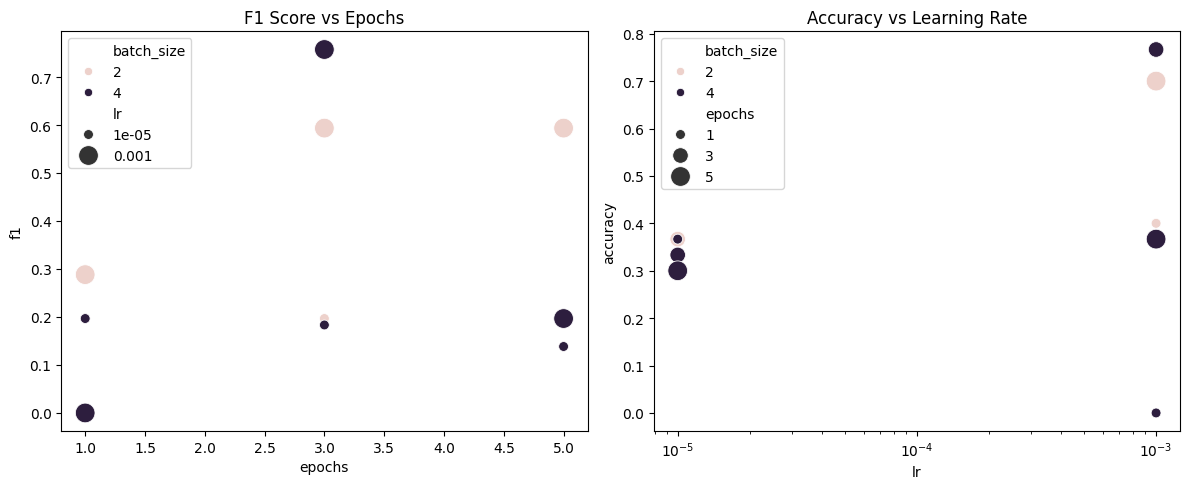

In [31]:
# Scatterplot
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(data=manual_df, x='epochs', y='f1', hue='batch_size', size='lr', sizes=(50,200))
plt.title("F1 Score vs Epochs")
plt.subplot(122)
sns.scatterplot(data=manual_df, x='lr', y='accuracy', hue='batch_size', size='epochs', sizes=(50,200))
plt.xscale('log')
plt.title("Accuracy vs Learning Rate")
plt.tight_layout()
plt.show()

In [33]:
# Final Comparison
comparison_data = {
    'Method': ['Manual Grid Search', 'Random Search', 'Bayesian Search'],
    'Accuracy': [manual_df['accuracy'].max(), random_result['accuracy'], bayes_result['accuracy']],
    'F1 Score': [manual_df['f1'].max(), random_result['f1'], bayes_result['f1']]
}
results_df = pd.DataFrame(comparison_data)
print("\nFinal Comparison:")
print(results_df)



Final Comparison:
               Method  Accuracy  F1 Score
0  Manual Grid Search  0.766667  0.757333
1       Random Search  0.966667  0.966750
2     Bayesian Search  1.000000  1.000000


# Theoretical Analysis

1. Epochs vs Performance: Generally direct relationship - more epochs allow better learning
2. Batch Size vs Performance: Inverse relationship - smaller batches provide more updates
3. Learning Rate: Optimal mid-range values perform best (1e-3 better than 1e-5 here)
4. Automated vs Manual: Automated search better - explores wider hyperparameter space efficiently
5. Best Approach: Bayesian optimization performs best, combining exploration/exploitation